In [5]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../dataset.csv")
for i in df.columns: 
    if i == "año": continue
    df[i] = df[i].str.replace("\n"," ")
#####################################################################
nw = ["introduccion","conclusiones","referencias"]                      # number of words
sa = ["resumen","introduccion","conclusiones"]                          # sentiment analysis
ng = ["titulo","resumen","introduccion","conclusiones","referencias"]   # n-grams
#####################################################################
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nw_dict = {}
for i in nw:
    nw_dict[i+"_nw"] = []
    for j,row in df.iterrows():
        tokens = word_tokenize(row[i])
        nw_dict[i+"_nw"].append(len(tokens))
#####################################################################
from textblob import TextBlob
sa_dict = {}
for i in sa:
    sa_dict[i+"_sa"] = []
    for j,row in df.iterrows():
        text  = row[i]
        senti = TextBlob(text).sentiment
        sa_dict[i+"_sa"].append((senti.polarity,senti.subjectivity))
#####################################################################               
from itertools import islice
import spacy
from collections import Counter
nlp = spacy.load('en_core_web_md')

def get_ngrams(text, n):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    remove_token = [" ","et","al"]
    tokens = [i for i in tokens if i not in remove_token]
    ngrams = zip(*[islice(tokens, i, None) for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

remove_ngram = ["video","google","game",
                "et al","study 1","gagnon 1985","green bavelier","bavelier 2003","frensch 1994",
                "greenfield 1994","v entertainment"]
ng_dict = {}
for i in ng:
    for n in range(1,4):
        ng_dict[i+"_ng"+str(n)] = []
        for j,row in df.iterrows():
            ngrams = get_ngrams(row[i], n)
            ngrams = [ngram for ngram in ngrams if not any(ss in ngram for ss in remove_ngram)] 
            ng_dict[i+"_ng"+str(n)].append(Counter(ngrams))
#####################################################################            
dataset = df.join(pd.DataFrame(nw_dict)).join(pd.DataFrame(sa_dict)).join(pd.DataFrame(ng_dict))
print(len(dataset))
dataset.columns

39
CPU times: user 42.8 s, sys: 359 ms, total: 43.1 s
Wall time: 43.1 s


Index(['fuente', 'busqueda', 'idioma', 'url', 'titulo', 'año', 'autores',
       'resumen', 'introduccion', 'conclusiones', 'referencias',
       'introduccion_nw', 'conclusiones_nw', 'referencias_nw', 'resumen_sa',
       'introduccion_sa', 'conclusiones_sa', 'titulo_ng1', 'titulo_ng2',
       'titulo_ng3', 'resumen_ng1', 'resumen_ng2', 'resumen_ng3',
       'introduccion_ng1', 'introduccion_ng2', 'introduccion_ng3',
       'conclusiones_ng1', 'conclusiones_ng2', 'conclusiones_ng3',
       'referencias_ng1', 'referencias_ng2', 'referencias_ng3'],
      dtype='object')

In [2]:
# plt.rcParams['font.family'] = 'Liberation Serif'
plt.rcParams.update({
    'axes.labelsize': 14,    # Font size for x and y labels
    'xtick.labelsize': 12,   # Font size for x-axis tick labels
    'ytick.labelsize': 12,   # Font size for y-axis tick labels
    'legend.fontsize': 12,   # Font size for legend
    'axes.titlesize': 16,    # Font size for plot title
    'figure.titlesize': 18,   # Font size for figure title (if you use fig.suptitle)
    'figure.figsize': [6, 4],  # Width, Height in inches
    'font.family':'Liberation Serif', 
})

# plotting the sum of an n-gram series

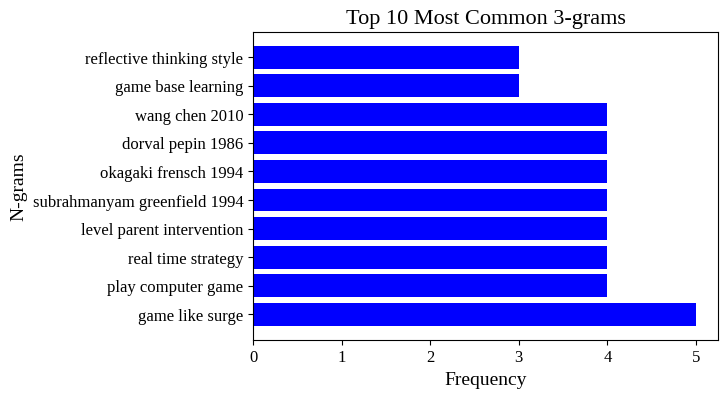

In [37]:
top = 10
n   = 3

ngram_freq = dataset['conclusiones_ng'+str(n)].sum() # Counter object
words, counts = zip(*ngram_freq.most_common(top))

# Create bar plot
plt.barh(words, counts, color='blue')
plt.title(f'Top {top} Most Common {n}-grams')
plt.ylabel('N-grams')
plt.xlabel('Frequency')
plt.show()

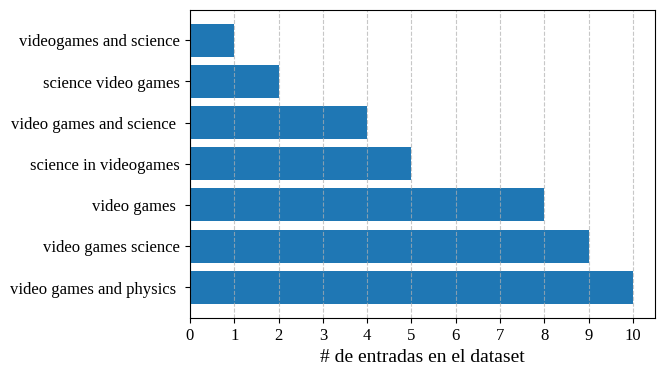

In [41]:
# plt.bar()
plt.barh(dataset.busqueda.value_counts().index,dataset.busqueda.value_counts())
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks([i for i in range(11)])
plt.xlabel("# de entradas en el dataset")
plt.show()

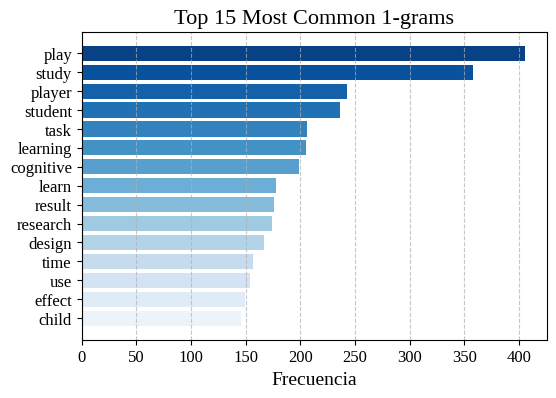

In [21]:
top = 15
n   = 1

ngram_freq = Counter()
for i in dataset.columns: 
    if (f"ng{n}" in i) and ("referencias" not in i): ngram_freq += dataset[i].sum() # Counter object

words, counts = zip(*ngram_freq.most_common(top))

# Create bar plot
palette = sns.color_palette("Blues_r", top)
plt.barh(words, counts, color=palette)
plt.title(f'Top {top} Most Common {n}-grams')
plt.xlabel('Frecuencia')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.xticks([i for i in range(0,39,2)])
plt.show()

# plotting sum of n-gram series by year intervals

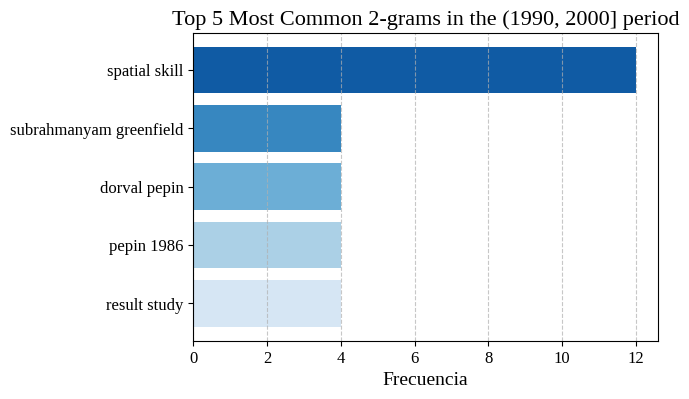

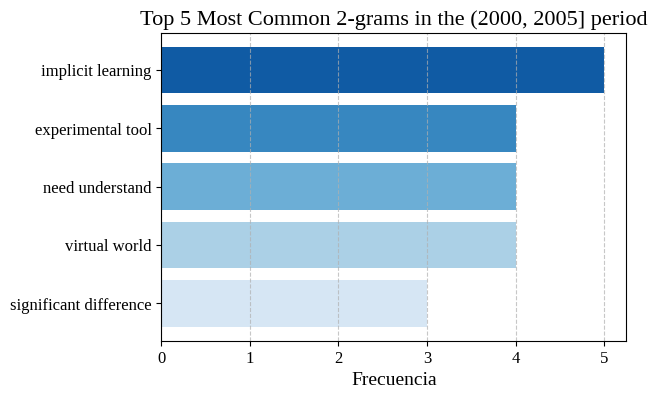

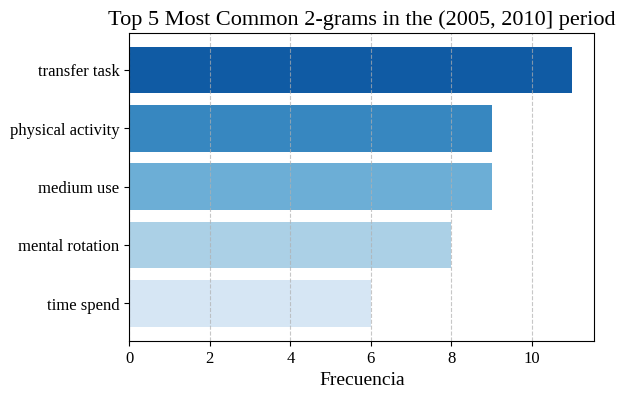

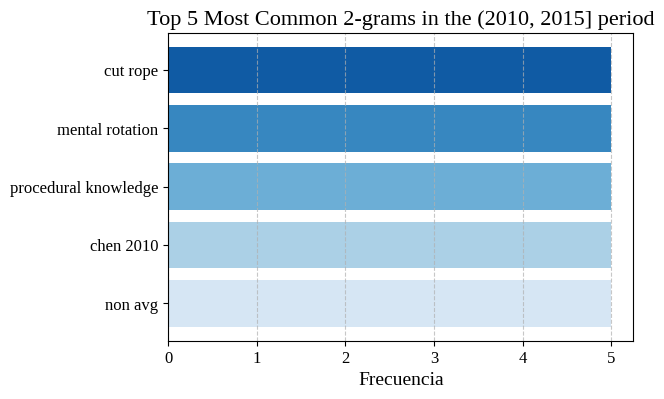

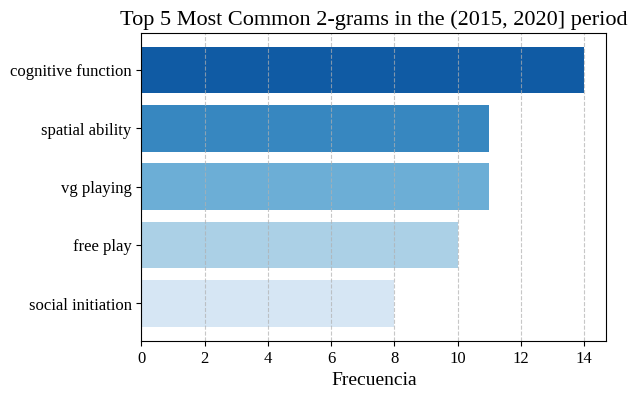

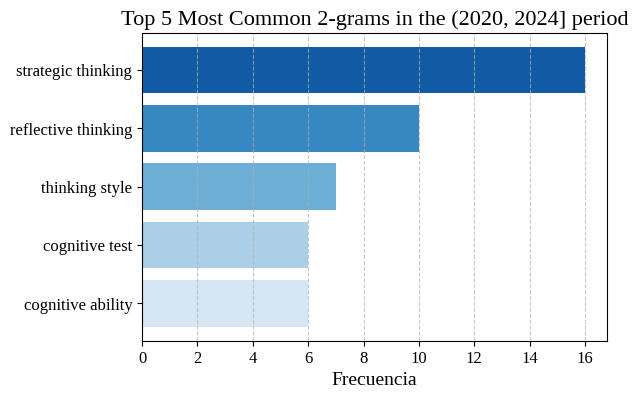

In [43]:
n   = 2
top = 5

bins = [1990,2000,2005,2010,2015,2020,2024]  # intervalos
dataset['year_group'] = pd.cut(dataset['año'], bins=bins, right=True)
grouped = dataset.groupby('year_group')['conclusiones_ng'+str(n)].sum()

for i in grouped.index:
#     g_index = grouped.index[5]
    freq_to_plot = grouped[i]
    words, counts = zip(*freq_to_plot.most_common(top))

    # Plot
    palette = sns.color_palette("Blues_r", top)
    plt.barh(words, counts, color=palette)
    plt.title(f'Top {top} Most Common {n}-grams in the {i} period')
    plt.xlabel('Frecuencia')
    plt.gca().invert_yaxis()

    plt.grid(axis='x', linestyle='--', alpha=0.7)
#     plt.tight_layout()
    plt.show()

# number of words

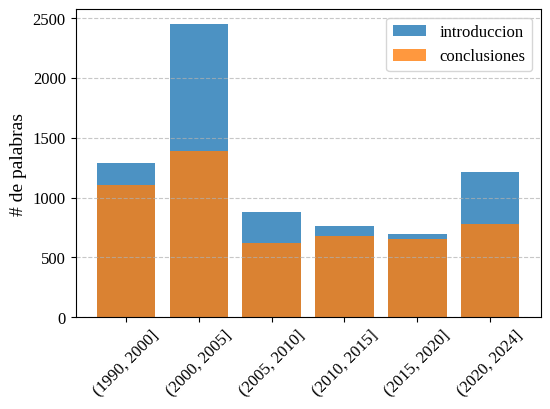

In [72]:
grouped1 = dataset.groupby('year_group')["introduccion_nw"].mean()
grouped2 = dataset.groupby('year_group')["conclusiones_nw"].mean()
year_labels = [str(i) for i in grouped.index]
h_pars = {"alpha":0.8}
plt.bar(year_labels, grouped1,**h_pars,label="introduccion")
plt.bar(year_labels, grouped2,**h_pars,label="conclusiones")
plt.xticks(rotation=45)
plt.ylabel("# de palabras")

plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
plt.legend()
plt.show()

In [47]:
dataset.columns

['introduccion', 'conclusiones', 'referencias']

['introduccion', 'conclusiones', 'referencias']


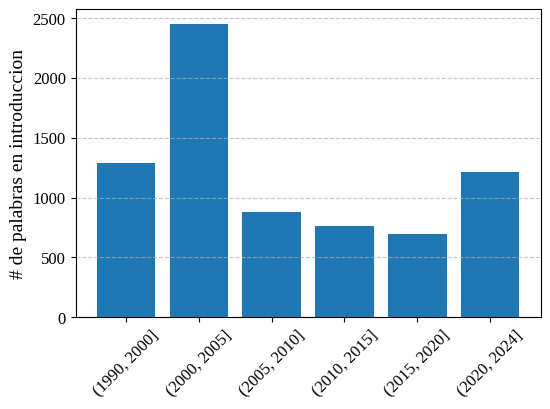

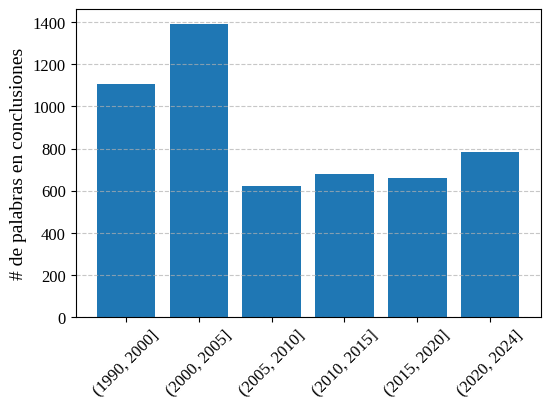

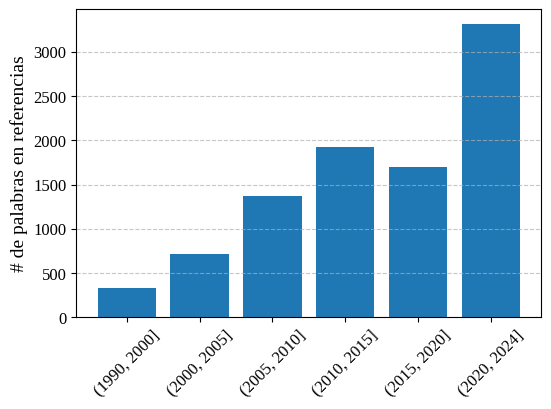

In [53]:
print(nw)
for i in nw:
    grouped = dataset.groupby('year_group')[i+"_nw"].mean()
    year_labels = [str(i) for i in grouped.index]
    plt.bar(year_labels, grouped)
    plt.xticks(rotation=45)
    plt.ylabel(f"# de palabras en {i}")

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.tight_layout()
    plt.show()

---------

# sentiment analysis

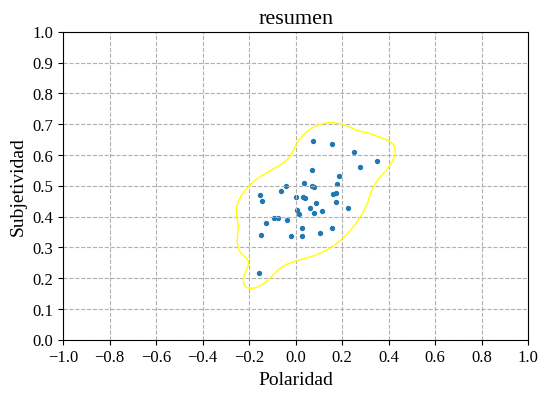

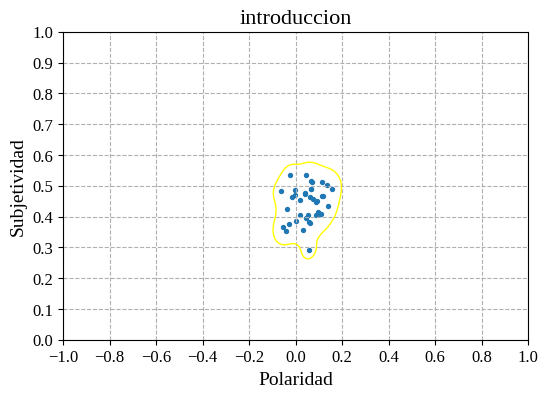

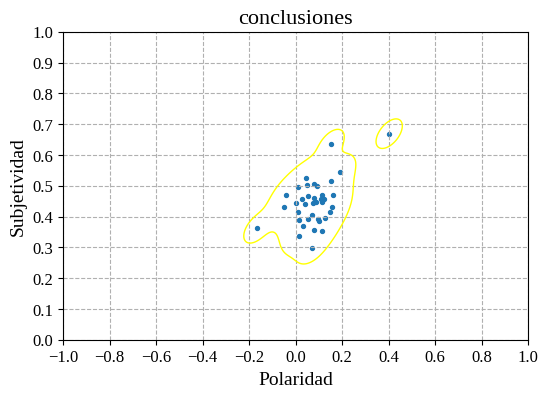

In [73]:
sa_list  = [i for i in dataset.columns if "sa" in i]

for i in sa_list:
    x = dataset[i].apply(lambda x: x[0])
    y = dataset[i].apply(lambda x: x[1])
    plt.scatter(x,y,s=8)
#     if "conclusiones" not in i: 
    sns.kdeplot( x=x, y=y, levels=1, color='yellow', linewidths=1) # contorno
    plt.grid(linestyle="--")
    plt.xticks([0.1*i for i in range(-10,11,2)])
    plt.yticks([0.1*i for i in range(0,11)])
    plt.xlabel("Polaridad")
    plt.ylabel("Subjetividad")
    plt.title(i.split("_")[0])
    plt.show()

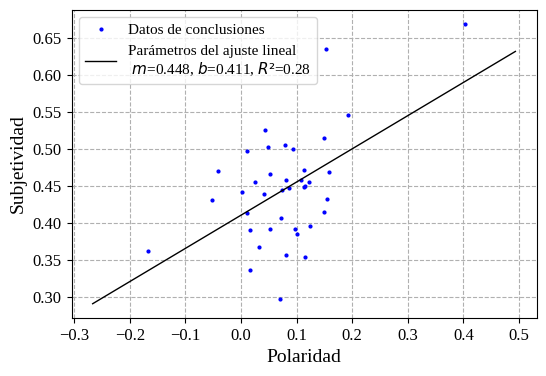

In [98]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
# plt.rcParams['figure.figsize']=(7,5) #tamaño en (x,y)
x = dataset["conclusiones_sa"].apply(lambda x: x[0])
y = dataset["conclusiones_sa"].apply(lambda x: x[1])
    
def line(x,m,b):
    return m*x + b

#FIT
initialGuess = [1.0,1.0]    
popt, pcov = curve_fit(line, x, y, initialGuess)
xFit = np.arange(x.min()-.1, x.max()+.1, 0.01)
 
# Valores ajustados
y_fitted = line(x, *popt)

# Calcular R²
residuals = y - y_fitted
ss_res = np.sum(residuals**2)  # Suma de los residuos al cuadrado
ss_tot = np.sum((y - np.mean(y))**2)  # Suma total de cuadrados
r_squared = 1 - (ss_res / ss_tot)
r_squared    
    
m  = round(popt[0],3)
b  = round(popt[1],3)
R2 = round(r_squared,2)

#PLOTS
plt.plot(x, y,'bo', label='Datos de conclusiones',markersize=2)
# plt.plot(xFit, line(xFit, *popt), 'black', label='Parámetros del ajuste lineal \n $m$=%.4f, $b$=%.4f' % tuple(popt),linewidth=1)
plt.plot(xFit, line(xFit, *popt), 'black', label=f'Parámetros del ajuste lineal \n $m$={m}, $b$={b}, $R²$={R2}',linewidth=1)
plt.grid(linestyle="--")
plt.legend(fontsize = 11)
# plt.legend()
plt.xlabel("Polaridad")
plt.ylabel("Subjetividad")
plt.show()




In [101]:
sa

['resumen', 'introduccion', 'conclusiones']

In [118]:
for i in sa:
    dataset[i+"_sa_pol"] = dataset[i+"_sa"].apply(lambda x: x[0])
    dataset[i+"_sa_sub"] = dataset[i+"_sa"].apply(lambda x: x[1])

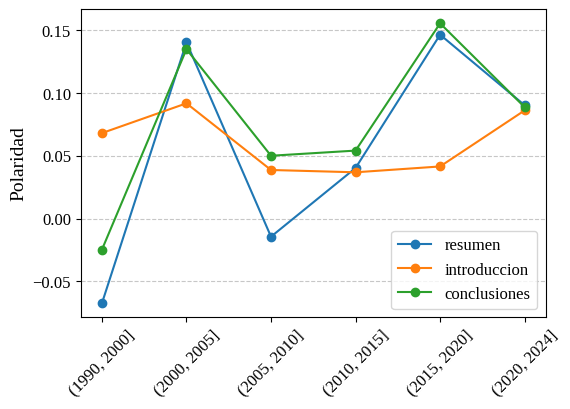

In [143]:
grouped1 = dataset.groupby('year_group')["resumen_sa_pol"].mean()
grouped2 = dataset.groupby('year_group')["introduccion_sa_pol"].mean()
grouped3 = dataset.groupby('year_group')["conclusiones_sa_pol"].mean()
year_labels = [str(i) for i in grouped.index]
h_pars = {"alpha":1,"marker":"o","linestyle":"-"}
plt.plot(year_labels, grouped1,**h_pars,label="resumen")
plt.plot(year_labels, grouped2,**h_pars,label="introduccion")
plt.plot(year_labels, grouped3,**h_pars,label="conclusiones")
plt.xticks(rotation=45)
plt.ylabel("Polaridad")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

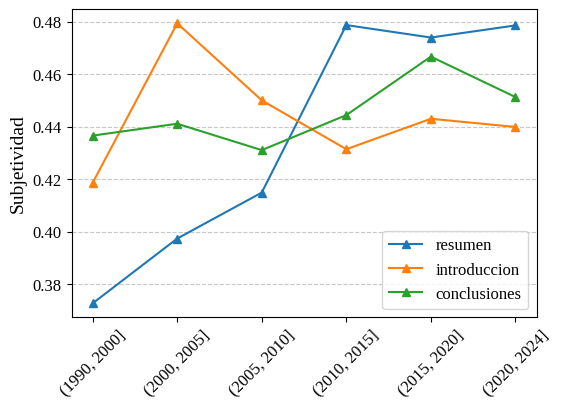

In [142]:
grouped1 = dataset.groupby('year_group')["resumen_sa_sub"].mean()
grouped2 = dataset.groupby('year_group')["introduccion_sa_sub"].mean()
grouped3 = dataset.groupby('year_group')["conclusiones_sa_sub"].mean()
year_labels = [str(i) for i in grouped.index]
h_pars = {"alpha":1,"marker":"^","linestyle":"-"}
plt.plot(year_labels, grouped1,**h_pars,label="resumen")
plt.plot(year_labels, grouped2,**h_pars,label="introduccion")
plt.plot(year_labels, grouped3,**h_pars,label="conclusiones")
plt.xticks(rotation=45)
plt.ylabel("Subjetividad")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()